# Test Best Models

Test notebook to generate the statistics of the different models found with AMS. First load the required libraries

In [1]:
import datetime
import logging
import sys
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K
from keras.models import model_from_json

from sklearn.model_selection import KFold
from scipy import stats

#sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
sys.path.append('/media/controlslab/DATA/Projects')

import ann_framework.aux_functions as aux_functions

import automatic_model_selection
from automatic_model_selection import Configuration
from ann_encoding_rules import Layers
import fetch_to_keras
#from CMAPSAuxFunctions import TrainValTensorBoard

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression, SequenceTunableModelClassification

#Data handlers
from ann_framework.data_handlers.data_handler_CMAPSS import CMAPSSDataHandler
from ann_framework.data_handlers.data_handler_MNIST import MNISTDataHandler
from ann_framework.data_handlers.data_handler_CIFAR10 import CIFAR10DataHandler

Using TensorFlow backend.


### Given a model, get the compiled model

In [2]:
def get_compiled_model(model, problem_type, optimizer_params=[]):
    """Obtain a keras compiled model"""
    
    #Shared parameters for the models
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    
    return model


def create_tunable_model(model_genotype, problem_type, input_shape, data_handler, model_number):
    
    K.clear_session()
    
    model = fetch_to_keras.decode_genotype(model_genotype, problem_type, input_shape, 1)
    
    model = get_compiled_model(model, problem_type, optimizer_params=[])
    
    if problem_type == 1:
        tModel = SequenceTunableModelRegression('ModelReg_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
    else:
        tModel = SequenceTunableModelClassification('ModelClass_SN_'+str(model_number), model, lib_type='keras', data_handler=data_handler)
        
    return tModel

### Load cmaps data handler

In [3]:
def cmapss_dhandler(data_scaler=None):

    #Selected as per CNN paper
    features = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 
    'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
    selected_indices = np.array([2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21])
    selected_features = list(features[i] for i in selected_indices-1)
    data_folder = '../CMAPSSData'

    window_size = 24
    window_stride = 1
    max_rul = 129

    dhandler_cmapss = CMAPSSDataHandler(data_folder, 1, selected_features,
                                       max_rul, window_size, window_stride, data_scaler=data_scaler)

    input_shape = (len(selected_features)*window_size, )

    return dhandler_cmapss

### Load models and evaluate model

In [4]:
def load_model(model_file, weights_file="", problem_type=1):
    
    p_type = ""
    
    # load json and create model
    json_file = open(model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    print("Loaded model from disk") 
        
    #Load weights if specified
    if weights_file != "":
        # load weights into new model
        loaded_model.load_weights(weights_file)
        print("Loaded weights from disk") 
    else:
        print("Model needs training")
        
    optimizer = Adam(lr=0.001, beta_1=0.5)
    
    if problem_type == 1:
        p_type = "regression"
        lossFunction = "mean_squared_error"
        metrics = ["mse"]
    elif problem_type == 2:
        p_type = "classification"
        lossFunction = "categorical_crossentropy"
        metrics = ["accuracy"]
    else:
        print("Problem type not defined")
        model = None
        return
    
    #Create and compile the models
    loaded_model.compile(optimizer = optimizer, loss = lossFunction, metrics = metrics)
    print("Created model for " + p_type + " with loss function " + lossFunction)

    return loaded_model
        
        

### Load each of the models and test them

In [5]:
best_model_folder = 'best_models'
"""
test_sets = {'cifar10':(CIFAR10DataHandler, None, 2), 
             'cmapss':(cmaps_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1), 
             'mnist':(MNISTDataHandler, None, 2)}
"""

#test_sets = {'cmapss':(cmapss_dhandler, MinMaxScaler(feature_range=(-1, 1)), 1)}
test_sets = {'mnist':(MNISTDataHandler, None, 2)}
#alpha_folders = ['alpha0.6', 'alpha0.8', 'alpha1']
#alpha_folders = ['alpha0.5']
#alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

results = {}

k = 5  #For 5-fold cross validation
evaluations_cv = np.zeros(k)
evaluations_test = np.zeros(k)

In [6]:
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for dataset in test_sets.keys():
    for alphaValue in alpha_values:
        
        model_file_name = 'yulin/alpha{}/bestModel_global.json'.format(alphaValue)
        weights_file_name = 'yulin/alpha{}/bestModel_global.h5'.format(alphaValue)
        trainable_count = 0
        
        print("Testing for "+model_file_name)
        
        results_key = dataset + "_" +  str(alphaValue)
        
        model_location = best_model_folder + '/' + dataset + '/' + model_file_name
        
        if weights_file_name != "":
            weights_location = best_model_folder + '/' + dataset + '/' + weights_file_name
        
        dhandler, data_scaler, problem_type = test_sets[dataset]

        #model = load_model(model_location, weights_location, problem_type)   
        
        data_handler = dhandler(data_scaler=data_scaler)
        data_handler.load_data(verbose = 1, unroll=True)
        data_handler.print_data()
        
        folds = list(KFold(n_splits=k, shuffle=True).split(data_handler.X_train))
        
        print('Validation on model:' + model_location)
        
        for j, (train_idx, val_idx) in enumerate(folds):

            print('\nExperiment on Fold ', j)
            
            K.clear_session()  #Clear the previous tensorflow graph 

            X_train_cv = data_handler.X_train[train_idx]
            y_train_cv = data_handler.y_train[train_idx]
            X_valid_cv = data_handler.X_train[val_idx]
            y_valid_cv = data_handler.y_train[val_idx]

            model = load_model(model_location, "", problem_type)
            model.summary()
            trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))

            model.fit(X_train_cv, y_train_cv, batch_size=512, epochs=100, verbose=1)

            evaluation_cv = model.evaluate(X_valid_cv, y_valid_cv)
            evaluation_test = model.evaluate(data_handler.X_test, data_handler.y_test)

            evaluations_cv[j] = evaluation_cv[1]
            evaluations_test[j] = evaluation_test[1]
            
        results[results_key] = (evaluations_cv.copy(), evaluations_test.copy(), trainable_count)
        

Testing for yulin/alpha0.2/bestModel_global.json
Loading data. Cross-Validation ratio 0
Printing shapes

Training data (X, y)
(60000, 784)
(60000, 10)
Testing data (X, y)
(10000, 784)
(10000, 10)
Printing first 5 elements

Training data (X, y)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Testing data (X, y)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Validation on model:best_models/mnist/yulin/alpha0.2/bestModel_global.json

Experiment on Fold  0
Loaded model from disk
Model needs training
Created mo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0019 - acc: 0.9996
Epoch 64/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0017 - acc: 0.9996
Epoch 65/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0027 - acc: 0.9992
Epoch 66/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0039 - acc: 0.9987
Epoch 67/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0051 - acc: 0.9983
Epoch 68/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0077 - acc: 0.9974
Epoch 69/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0019 - acc: 0.9996
Epoch 70/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0027 - acc: 0.9992
Epoch 71/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0032 - acc: 0.9989
Epoch 72/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0031 - acc: 0.9990
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0085 - acc: 0.9977
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0088 - acc: 0.9975
Epoch 35/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.9975
Epoch 36/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0069 - acc: 0.9981
Epoch 37/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0066 - acc: 0.9982
Epoch 38/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0062 - acc: 0.9983
Epoch 39/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0050 - acc: 0.9989
Epoch 40/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0057 - acc: 0.9982
Epoch 41/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0047 - acc: 0.9987
Epoch 42/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0042 - acc: 0.9989
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1820 - acc: 0.9470
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1486 - acc: 0.9565
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1252 - acc: 0.9631
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1072 - acc: 0.9683
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0931 - acc: 0.9718
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0813 - acc: 0.9757
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0725 - acc: 0.9775
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0636 - acc: 0.9810
Epoch 11/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0568 - acc: 0.9825
Epoch 12/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0500 - acc: 0.9850
Epoch 13/

48000/48000 [==============================] - 0s 4us/step - loss: 0.0041 - acc: 0.9986
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 0.9985
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0018 - acc: 0.9995
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0019 - acc: 0.9995
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0031 - acc: 0.9990
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0045 - acc: 0.9986
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0033 - acc: 0.9989
Epoch 91/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0017 - acc: 0.9995
Epoch 92/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0010 - acc: 0.9998
Epoch 93/100
48000/48000 [==============================] - 0s 4us/step - loss: 7.1972e-04 - acc: 0.9999

48000/48000 [==============================] - 0s 4us/step - loss: 0.0031 - acc: 0.9993
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0046 - acc: 0.9985
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 0.9985
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0062 - acc: 0.9982
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0053 - acc: 0.9983
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0024 - acc: 0.9995
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0037 - acc: 0.9989
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0023 - acc: 0.9994
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0026 - acc: 0.9993
Epoch 63/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0033 - acc: 0.9991
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0165 - acc: 0.9952
Epoch 25/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0154 - acc: 0.9956
Epoch 26/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0143 - acc: 0.9958
Epoch 27/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0130 - acc: 0.9961
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0130 - acc: 0.9961
Epoch 29/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0108 - acc: 0.9970
Epoch 30/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0096 - acc: 0.9973
Epoch 31/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0097 - acc: 0.9975
Epoch 32/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9973
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0085 - acc: 0.9977
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 8us/step - loss: 0.6601 - acc: 0.8339
Epoch 2/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.2611 - acc: 0.9254
Epoch 3/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1973 - acc: 0.9426
Epoch 4/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1579 - acc: 0.9539
Epoch 5/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1309 - acc: 0.9617
Epoch 6/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.1114 - acc: 0.9668
Epoch 7/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0947 - acc: 0.9725
Epoch 8/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0829 - acc: 0.9763
Epoch 9/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0717 - acc: 0.9792
Epoch 10/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0635 - acc: 0.9816

48000/48000 [==============================] - 0s 5us/step - loss: 1.2237e-04 - acc: 1.0000
Epoch 81/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.1624e-04 - acc: 1.0000
Epoch 82/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.0949e-04 - acc: 1.0000
Epoch 83/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.0341e-04 - acc: 1.0000
Epoch 84/100
48000/48000 [==============================] - 0s 5us/step - loss: 9.7512e-05 - acc: 1.0000
Epoch 85/100
48000/48000 [==============================] - 0s 5us/step - loss: 9.1986e-05 - acc: 1.0000
Epoch 86/100
48000/48000 [==============================] - 0s 5us/step - loss: 8.7483e-05 - acc: 1.0000
Epoch 87/100
48000/48000 [==============================] - 0s 5us/step - loss: 8.2433e-05 - acc: 1.0000
Epoch 88/100
48000/48000 [==============================] - 0s 5us/step - loss: 7.8768e-05 - acc: 1.0000
Epoch 89/100
48000/48000 [==============================] - 0s 5us/s

48000/48000 [==============================] - 0s 5us/step - loss: 8.1568e-04 - acc: 1.0000
Epoch 48/100
48000/48000 [==============================] - 0s 5us/step - loss: 7.4232e-04 - acc: 1.0000
Epoch 49/100
48000/48000 [==============================] - 0s 5us/step - loss: 6.7882e-04 - acc: 1.0000
Epoch 50/100
48000/48000 [==============================] - 0s 5us/step - loss: 6.3305e-04 - acc: 1.0000
Epoch 51/100
48000/48000 [==============================] - 0s 5us/step - loss: 5.9089e-04 - acc: 1.0000
Epoch 52/100
48000/48000 [==============================] - 0s 5us/step - loss: 5.4334e-04 - acc: 1.0000
Epoch 53/100
48000/48000 [==============================] - 0s 5us/step - loss: 5.0656e-04 - acc: 1.0000
Epoch 54/100
48000/48000 [==============================] - 0s 5us/step - loss: 4.7336e-04 - acc: 1.0000
Epoch 55/100
48000/48000 [==============================] - 0s 5us/step - loss: 4.4447e-04 - acc: 1.0000
Epoch 56/100
48000/48000 [==============================] - 0s 5us/s

48000/48000 [==============================] - 0s 5us/step - loss: 0.0437 - acc: 0.9878
Epoch 14/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0403 - acc: 0.9882
Epoch 15/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0351 - acc: 0.9900
Epoch 16/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0308 - acc: 0.9915
Epoch 17/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0265 - acc: 0.9929
Epoch 18/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0244 - acc: 0.9929
Epoch 19/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0204 - acc: 0.9943
Epoch 20/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0186 - acc: 0.9950
Epoch 21/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0155 - acc: 0.9961
Epoch 22/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0139 - acc: 0.9967
Epo

48000/48000 [==============================] - 0s 5us/step - loss: 2.4594e-05 - acc: 1.0000
Epoch 93/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.3095e-05 - acc: 1.0000
Epoch 94/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.2004e-05 - acc: 1.0000
Epoch 95/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.0740e-05 - acc: 1.0000
Epoch 96/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.9702e-05 - acc: 1.0000
Epoch 97/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.8462e-05 - acc: 1.0000
Epoch 98/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.7687e-05 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.6659e-05 - acc: 1.0000
Epoch 100/100
10000/10000 [==============================] - 0s 15us/step

Experiment on Fold  3
Loaded model from disk
Model needs training
Created model for classification

48000/48000 [==============================] - 0s 4us/step - loss: 2.0072e-04 - acc: 1.0000
Epoch 60/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.8941e-04 - acc: 1.0000
Epoch 61/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.7817e-04 - acc: 1.0000
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 1.6752e-04 - acc: 1.0000
Epoch 63/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.5678e-04 - acc: 1.0000
Epoch 64/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.4620e-04 - acc: 1.0000
Epoch 65/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.3751e-04 - acc: 1.0000
Epoch 66/100
48000/48000 [==============================] - 0s 4us/step - loss: 1.2970e-04 - acc: 1.0000
Epoch 67/100
48000/48000 [==============================] - 0s 5us/step - loss: 1.2153e-04 - acc: 1.0000
Epoch 68/100
48000/48000 [==============================] - 0s 5us/s

48000/48000 [==============================] - 0s 5us/step - loss: 0.0116 - acc: 0.9973
Epoch 27/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0067 - acc: 0.9989
Epoch 28/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0049 - acc: 0.9995
Epoch 29/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0042 - acc: 0.9997
Epoch 30/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0038 - acc: 0.9996
Epoch 31/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0042 - acc: 0.9995
Epoch 32/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0040 - acc: 0.9994
Epoch 33/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0032 - acc: 0.9996
Epoch 34/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0829 - acc: 0.9800
Epoch 35/100
48000/48000 [==============================] - 0s 5us/step - loss: 0.0111 - acc: 0.9969
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.7546 - acc: 0.7962
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2830 - acc: 0.9196
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2237 - acc: 0.9356
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1906 - acc: 0.9447
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1663 - acc: 0.9515
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1482 - acc: 0.9571
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1319 - acc: 0.9612
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1187 - acc: 0.9650
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1082 - acc: 0.9684
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0989 - acc: 0.9712

48000/48000 [==============================] - 0s 4us/step - loss: 9.6048e-04 - acc: 1.0000
Epoch 83/100
48000/48000 [==============================] - 0s 4us/step - loss: 9.3568e-04 - acc: 1.0000
Epoch 84/100
48000/48000 [==============================] - 0s 4us/step - loss: 9.0527e-04 - acc: 1.0000
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 8.8992e-04 - acc: 1.0000
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 8.6240e-04 - acc: 1.0000
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 8.4013e-04 - acc: 1.0000
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 8.3806e-04 - acc: 1.0000
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 7.9698e-04 - acc: 1.0000
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 7.7170e-04 - acc: 1.0000
Epoch 91/100
48000/48000 [==============================] - 0s 4us/s

48000/48000 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 0.9998
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0043 - acc: 0.9997
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0042 - acc: 0.9998
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0036 - acc: 0.9999
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0045 - acc: 0.9996
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0031 - acc: 0.9999
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0031 - acc: 0.9999
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0029 - acc: 0.9999
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0025 - acc: 1.0000
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0024 - acc: 0.9999
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0423 - acc: 0.9882
Epoch 23/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0403 - acc: 0.9883
Epoch 24/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0381 - acc: 0.9897
Epoch 25/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0351 - acc: 0.9904
Epoch 26/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0330 - acc: 0.9909
Epoch 27/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0308 - acc: 0.9916
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0290 - acc: 0.9926
Epoch 29/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0272 - acc: 0.9928
Epoch 30/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0259 - acc: 0.9939
Epoch 31/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0241 - acc: 0.9940
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.7469 - acc: 0.8043
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2719 - acc: 0.9227
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2132 - acc: 0.9392
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1786 - acc: 0.9482
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1563 - acc: 0.9552
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1387 - acc: 0.9606
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1256 - acc: 0.9639
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1137 - acc: 0.9671
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1059 - acc: 0.9695
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0958 - acc: 0.9727

48000/48000 [==============================] - 0s 4us/step - loss: 5.8511e-04 - acc: 1.0000
Epoch 82/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.5796e-04 - acc: 1.0000
Epoch 83/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.3055e-04 - acc: 1.0000
Epoch 84/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.1194e-04 - acc: 1.0000
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 4.8999e-04 - acc: 1.0000
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 4.6920e-04 - acc: 1.0000
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 4.4920e-04 - acc: 1.0000
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 4.3536e-04 - acc: 1.0000
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1677 - acc: 0.9785
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step 

48000/48000 [==============================] - 0s 4us/step - loss: 0.0049 - acc: 0.9997
Epoch 52/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0047 - acc: 0.9997
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0046 - acc: 0.9996
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0054 - acc: 0.9993
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0063 - acc: 0.9991
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0036 - acc: 0.9999
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0043 - acc: 0.9995
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0039 - acc: 0.9996
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0036 - acc: 0.9996
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0027 - acc: 0.9999
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0919 - acc: 0.9731
Epoch 13/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0860 - acc: 0.9754
Epoch 14/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0806 - acc: 0.9768
Epoch 15/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0753 - acc: 0.9783
Epoch 16/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0709 - acc: 0.9790
Epoch 17/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0660 - acc: 0.9804
Epoch 18/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0622 - acc: 0.9815
Epoch 19/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0581 - acc: 0.9829
Epoch 20/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0545 - acc: 0.9841
Epoch 21/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0519 - acc: 0.9848
Epo

Epoch 93/100
48000/48000 [==============================] - 0s 4us/step - loss: 6.5060e-04 - acc: 1.0000
Epoch 94/100
48000/48000 [==============================] - 0s 4us/step - loss: 6.1957e-04 - acc: 1.0000
Epoch 95/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.8904e-04 - acc: 1.0000
Epoch 96/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.6570e-04 - acc: 1.0000
Epoch 97/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.4203e-04 - acc: 1.0000
Epoch 98/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.3303e-04 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 4.9127e-04 - acc: 1.0000
Epoch 100/100
10000/10000 [==============================] - 0s 14us/step

Experiment on Fold  1
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_______________________________________________

48000/48000 [==============================] - 0s 4us/step - loss: 0.0036 - acc: 0.9998
Epoch 65/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0032 - acc: 0.9998
Epoch 66/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0029 - acc: 0.9998
Epoch 67/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0028 - acc: 0.9999
Epoch 68/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0025 - acc: 0.9999
Epoch 69/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0042 - acc: 0.9995
Epoch 70/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0029 - acc: 0.9999
Epoch 71/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0022 - acc: 1.0000
Epoch 72/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0019 - acc: 1.0000
Epoch 73/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0017 - acc: 1.0000
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0214 - acc: 0.9949
Epoch 36/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0198 - acc: 0.9951
Epoch 37/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0192 - acc: 0.9954
Epoch 38/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0177 - acc: 0.9962
Epoch 39/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0170 - acc: 0.9962
Epoch 40/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0158 - acc: 0.9964
Epoch 41/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0145 - acc: 0.9971
Epoch 42/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0143 - acc: 0.9970
Epoch 43/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0124 - acc: 0.9977
Epoch 44/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0117 - acc: 0.9976
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1658 - acc: 0.9519
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1468 - acc: 0.9573
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1320 - acc: 0.9607
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1194 - acc: 0.9648
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1094 - acc: 0.9679
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1013 - acc: 0.9697
Epoch 11/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0926 - acc: 0.9731
Epoch 12/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0858 - acc: 0.9751
Epoch 13/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0796 - acc: 0.9770
Epoch 14/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0745 - acc: 0.9781
Epoch 1

48000/48000 [==============================] - 0s 4us/step - loss: 0.0013 - acc: 1.0000
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 9.7257e-04 - acc: 1.0000
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 8.2505e-04 - acc: 1.0000
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 7.3764e-04 - acc: 1.0000
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 6.9051e-04 - acc: 1.0000
Epoch 91/100
48000/48000 [==============================] - 0s 4us/step - loss: 6.4154e-04 - acc: 1.0000
Epoch 92/100
48000/48000 [==============================] - 0s 4us/step - loss: 6.0466e-04 - acc: 1.0000
Epoch 93/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.7341e-04 - acc: 1.0000
Epoch 94/100
48000/48000 [==============================] - 0s 4us/step - loss: 5.4733e-04 - acc: 1.0000
Epoch 95/100
48000/48000 [==============================] - 0s 4us/step 

48000/48000 [==============================] - 0s 4us/step - loss: 0.0072 - acc: 0.9992
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0073 - acc: 0.9991
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0066 - acc: 0.9992
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0061 - acc: 0.9994
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0054 - acc: 0.9996
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0057 - acc: 0.9993
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0052 - acc: 0.9995
Epoch 63/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 0.9995
Epoch 64/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0045 - acc: 0.9996
Epoch 65/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0039 - acc: 0.9998
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0996 - acc: 0.9738
Epoch 20/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0952 - acc: 0.9742
Epoch 21/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0909 - acc: 0.9757
Epoch 22/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0869 - acc: 0.9768
Epoch 23/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0832 - acc: 0.9781
Epoch 24/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0796 - acc: 0.9790
Epoch 25/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0763 - acc: 0.9804
Epoch 26/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0732 - acc: 0.9805
Epoch 27/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0705 - acc: 0.9820
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0676 - acc: 0.9830
Epo

10000/10000 [==============================] - 0s 13us/step

Experiment on Fold  1
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 48)                37680     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 0.8814 - acc: 0.7836
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3913 - acc: 0.9009
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3059 - acc: 0.9175
Epoch 4/100
48000/48000 [=====

48000/48000 [==============================] - 0s 4us/step - loss: 0.0118 - acc: 0.9991
Epoch 73/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0114 - acc: 0.9993
Epoch 74/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0109 - acc: 0.9994
Epoch 75/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0105 - acc: 0.9994
Epoch 76/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0101 - acc: 0.9994
Epoch 77/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0097 - acc: 0.9995
Epoch 78/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0093 - acc: 0.9995
Epoch 79/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0089 - acc: 0.9996
Epoch 80/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0085 - acc: 0.9996
Epoch 81/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0081 - acc: 0.9997
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0344 - acc: 0.9933
Epoch 45/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0332 - acc: 0.9935
Epoch 46/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0321 - acc: 0.9938
Epoch 47/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0308 - acc: 0.9940
Epoch 48/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0297 - acc: 0.9943
Epoch 49/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0283 - acc: 0.9950
Epoch 50/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0273 - acc: 0.9953
Epoch 51/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0263 - acc: 0.9955
Epoch 52/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0252 - acc: 0.9959
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0241 - acc: 0.9962
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1154 - acc: 0.9680
Epoch 17/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1100 - acc: 0.9696
Epoch 18/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1049 - acc: 0.9709
Epoch 19/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1004 - acc: 0.9725
Epoch 20/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0959 - acc: 0.9740
Epoch 21/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0918 - acc: 0.9753
Epoch 22/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0877 - acc: 0.9761
Epoch 23/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0841 - acc: 0.9780
Epoch 24/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0804 - acc: 0.9788
Epoch 25/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0774 - acc: 0.9798
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0040 - acc: 1.0000
Epoch 98/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0038 - acc: 1.0000
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0037 - acc: 1.0000
Epoch 100/100
10000/10000 [==============================] - 0s 13us/step

Experiment on Fold  4
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 48)                37680     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48000/48000 [=

48000/48000 [==============================] - 0s 4us/step - loss: 0.0126 - acc: 0.9992
Epoch 70/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0122 - acc: 0.9992
Epoch 71/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0117 - acc: 0.9993
Epoch 72/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0112 - acc: 0.9993
Epoch 73/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0108 - acc: 0.9994
Epoch 74/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0103 - acc: 0.9995
Epoch 75/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0098 - acc: 0.9996
Epoch 76/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0094 - acc: 0.9995
Epoch 77/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0090 - acc: 0.9996
Epoch 78/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.9996
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1188 - acc: 0.9665
Epoch 32/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1171 - acc: 0.9669
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1157 - acc: 0.9673
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1134 - acc: 0.9677
Epoch 35/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1117 - acc: 0.9680
Epoch 36/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1109 - acc: 0.9684
Epoch 37/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1083 - acc: 0.9694
Epoch 38/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1071 - acc: 0.9689
Epoch 39/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1051 - acc: 0.9701
Epoch 40/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1041 - acc: 0.9699
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.4458 - acc: 0.8809
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3354 - acc: 0.9060
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2922 - acc: 0.9168
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2665 - acc: 0.9243
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2482 - acc: 0.9293
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2348 - acc: 0.9326
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2236 - acc: 0.9368
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2135 - acc: 0.9387
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2058 - acc: 0.9414
Epoch 11/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1987 - acc: 0.9436
Epoch 12/1

48000/48000 [==============================] - 0s 4us/step - loss: 0.0767 - acc: 0.9776
Epoch 84/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0761 - acc: 0.9772
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0754 - acc: 0.9774
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0748 - acc: 0.9777
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0741 - acc: 0.9779
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0740 - acc: 0.9783
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0729 - acc: 0.9788
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0725 - acc: 0.9781
Epoch 91/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0724 - acc: 0.9786
Epoch 92/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0708 - acc: 0.9798
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0855 - acc: 0.9741
Epoch 55/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0852 - acc: 0.9749
Epoch 56/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0845 - acc: 0.9745
Epoch 57/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0825 - acc: 0.9754
Epoch 58/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0823 - acc: 0.9748
Epoch 59/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0813 - acc: 0.9757
Epoch 60/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0807 - acc: 0.9756
Epoch 61/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0795 - acc: 0.9763
Epoch 62/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0787 - acc: 0.9760
Epoch 63/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0777 - acc: 0.9772
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1285 - acc: 0.9619
Epoch 26/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1262 - acc: 0.9634
Epoch 27/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1237 - acc: 0.9637
Epoch 28/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1212 - acc: 0.9641
Epoch 29/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1185 - acc: 0.9650
Epoch 30/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1161 - acc: 0.9657
Epoch 31/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1142 - acc: 0.9665
Epoch 32/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1124 - acc: 0.9673
Epoch 33/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1106 - acc: 0.9675
Epoch 34/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1092 - acc: 0.9670
Epo

Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 1.2535 - acc: 0.6281
Epoch 2/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.4320 - acc: 0.8834
Epoch 3/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.3214 - acc: 0.9120
Epoch 4/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2777 - acc: 0.9228
Epoch 5/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2541 - acc: 0.9279
Epoch 6/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2376 - acc: 0.9331
Epoch 7/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2249 - acc: 0.9355
Epoch 8/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2149 - acc: 0.9390
Epoch 9/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.2058 - acc: 0.9403
Epoch 10/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1972 - acc: 0.9436

48000/48000 [==============================] - 0s 4us/step - loss: 0.0641 - acc: 0.9813
Epoch 83/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0628 - acc: 0.9817
Epoch 84/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0624 - acc: 0.9818
Epoch 85/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0620 - acc: 0.9825
Epoch 86/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0610 - acc: 0.9822
Epoch 87/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0611 - acc: 0.9825
Epoch 88/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0600 - acc: 0.9825
Epoch 89/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0596 - acc: 0.9832
Epoch 90/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0596 - acc: 0.9825
Epoch 91/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0580 - acc: 0.9833
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1264 - acc: 0.9625
Epoch 46/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1252 - acc: 0.9625
Epoch 47/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1241 - acc: 0.9634
Epoch 48/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1230 - acc: 0.9637
Epoch 49/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1214 - acc: 0.9642
Epoch 50/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1206 - acc: 0.9644
Epoch 51/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1196 - acc: 0.9646
Epoch 52/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1185 - acc: 0.9649
Epoch 53/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1179 - acc: 0.9648
Epoch 54/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1166 - acc: 0.9658
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1977 - acc: 0.9446
Epoch 18/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1934 - acc: 0.9452
Epoch 19/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1891 - acc: 0.9465
Epoch 20/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1853 - acc: 0.9474
Epoch 21/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1814 - acc: 0.9487
Epoch 22/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1777 - acc: 0.9494
Epoch 23/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1749 - acc: 0.9502
Epoch 24/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1718 - acc: 0.9511
Epoch 25/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1686 - acc: 0.9520
Epoch 26/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1659 - acc: 0.9527
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.0897 - acc: 0.9741
Epoch 99/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.0891 - acc: 0.9741
Epoch 100/100
10000/10000 [==============================] - 0s 13us/step

Experiment on Fold  2
Loaded model from disk
Model needs training
Created model for classification with loss function categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (Dense)                   (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48000/48000 [==============================] - 0s 6us/step - loss: 1.1820 - acc: 0.6724
Epoch 2/100
48000/48000 [==

48000/48000 [==============================] - 0s 4us/step - loss: 0.1072 - acc: 0.9687
Epoch 71/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1068 - acc: 0.9683
Epoch 72/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1063 - acc: 0.9687
Epoch 73/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1056 - acc: 0.9689
Epoch 74/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1051 - acc: 0.9689
Epoch 75/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1043 - acc: 0.9693
Epoch 76/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1036 - acc: 0.9695
Epoch 77/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1033 - acc: 0.9697
Epoch 78/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1025 - acc: 0.9700
Epoch 79/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1019 - acc: 0.9699
Epo

48000/48000 [==============================] - 0s 4us/step - loss: 0.1322 - acc: 0.9620
Epoch 43/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1312 - acc: 0.9626
Epoch 44/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1294 - acc: 0.9626
Epoch 45/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1285 - acc: 0.9632
Epoch 46/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1272 - acc: 0.9634
Epoch 47/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1260 - acc: 0.9639
Epoch 48/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1254 - acc: 0.9641
Epoch 49/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1239 - acc: 0.9647
Epoch 50/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1231 - acc: 0.9651
Epoch 51/100
48000/48000 [==============================] - 0s 4us/step - loss: 0.1221 - acc: 0.9649
Epo

48000/48000 [==============================] - 0s 3us/step - loss: 0.2164 - acc: 0.9398
Epoch 15/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2104 - acc: 0.9411
Epoch 16/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2052 - acc: 0.9425
Epoch 17/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.2001 - acc: 0.9438
Epoch 18/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1950 - acc: 0.9450
Epoch 19/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1905 - acc: 0.9466
Epoch 20/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1862 - acc: 0.9471
Epoch 21/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1823 - acc: 0.9487
Epoch 22/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1788 - acc: 0.9493
Epoch 23/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.1753 - acc: 0.9502
Epo

48000/48000 [==============================] - 0s 3us/step - loss: 0.0916 - acc: 0.9730
Epoch 96/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0911 - acc: 0.9738
Epoch 97/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0903 - acc: 0.9735
Epoch 98/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0902 - acc: 0.9734
Epoch 99/100
48000/48000 [==============================] - 0s 3us/step - loss: 0.0897 - acc: 0.9735
Epoch 100/100
10000/10000 [==============================] - 0s 13us/step


### Print the stats

In [7]:
model_sizes = []
cv_errors = []
test_errors = []
alphas = []

for key in results.keys():
    
    print("\nStats for: ")
    print(key)
    evaluations_cv, evaluations_test, model_size = results[key]
    
    
    print("\nModel size: %d"%model_size)
    
    print("\nCrossVal stats: ")
    print(evaluations_cv)
    cv_stats = stats.describe(evaluations_cv)
    print(cv_stats)
    
    print("\nTest stats: ")
    test_stats = stats.describe(evaluations_test)
    print(test_stats)
    
    model_sizes.append(model_size)
    cv_errors.append(cv_stats[2])
    test_errors.append(test_stats[2])
    key_alphas = key.split('_')
    alphas.append(key_alphas[1])

{'mnist_0.2': (array([0.97858333, 0.97691667, 0.97716667, 0.97725   , 0.97758333]), array([0.9805, 0.9819, 0.9785, 0.9774, 0.9772]), 101706), 'mnist_0.3': (array([0.973     , 0.9735    , 0.97158333, 0.97333333, 0.97258333]), array([0.975 , 0.9741, 0.9755, 0.973 , 0.9732]), 63370), 'mnist_0.4': (array([0.97191667, 0.96941667, 0.97025   , 0.96941667, 0.9705    ]), array([0.9749, 0.9714, 0.9736, 0.9734, 0.9721]), 47722), 'mnist_0.5': (array([0.97116667, 0.97241667, 0.97025   , 0.96908333, 0.96925   ]), array([0.9718, 0.9681, 0.9691, 0.9708, 0.9735]), 40522), 'mnist_0.6': (array([0.96233333, 0.96316667, 0.96625   , 0.96775   , 0.966     ]), array([0.9663, 0.9672, 0.9687, 0.9677, 0.9687]), 38170), 'mnist_0.7': (array([0.94783333, 0.95108333, 0.949     , 0.95191667, 0.95075   ]), array([0.9572, 0.9512, 0.952 , 0.9541, 0.9534]), 13218), 'mnist_0.8': (array([0.94833333, 0.94675   , 0.94908333, 0.94925   , 0.9495    ]), array([0.9519, 0.9521, 0.951 , 0.9554, 0.9554]), 12730)}

Stats for: 
mnist

In [8]:
print(alphas)

['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8']


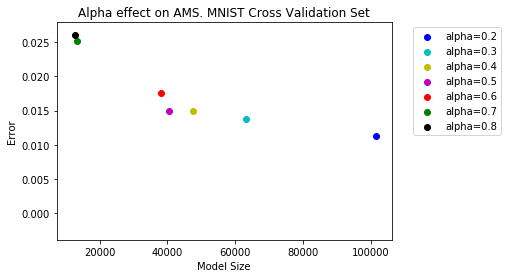

In [13]:
np_sizes = np.array(model_sizes)

np_cv_errors = 1 - np.array(np.sqrt(cv_errors)) #Used for accuracy to measure error
np_alphas = np.array(alphas)

colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
n1 = plt.scatter(np_sizes[0], np_cv_errors[0], color = colors[0], label = 'alpha='+np_alphas[0])
n2 = plt.scatter(np_sizes[1], np_cv_errors[1], color = colors[1], label = 'alpha='+np_alphas[1])
n3 = plt.scatter(np_sizes[2], np_cv_errors[2], color = colors[2], label = 'alpha='+np_alphas[2])
n4 = plt.scatter(np_sizes[3], np_cv_errors[3], color = colors[3], label = 'alpha='+np_alphas[3])
n5 = plt.scatter(np_sizes[4], np_cv_errors[4], color = colors[4], label = 'alpha='+np_alphas[4])
n6 = plt.scatter(np_sizes[5], np_cv_errors[5], color = colors[5], label = 'alpha='+np_alphas[5]) 
n7 = plt.scatter(np_sizes[6], np_cv_errors[6], color = colors[6], label = 'alpha='+np_alphas[6])

plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel('Model Size')
plt.ylabel('Error')
plt.title("Alpha effect on AMS. MNIST Cross Validation Set")
plt.show()

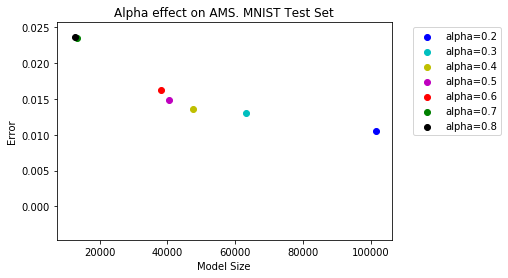

In [15]:
np_sizes = np.array(model_sizes)

np_test_errors = 1 - np.array(np.sqrt(test_errors)) #Used for accuracy to measure error
np_alphas = np.array(alphas)

colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
n1 = plt.scatter(np_sizes[0], np_test_errors[0], color = colors[0], label = 'alpha='+np_alphas[0])
n2 = plt.scatter(np_sizes[1], np_test_errors[1], color = colors[1], label = 'alpha='+np_alphas[1])
n3 = plt.scatter(np_sizes[2], np_test_errors[2], color = colors[2], label = 'alpha='+np_alphas[2])
n4 = plt.scatter(np_sizes[3], np_test_errors[3], color = colors[3], label = 'alpha='+np_alphas[3])
n5 = plt.scatter(np_sizes[4], np_test_errors[4], color = colors[4], label = 'alpha='+np_alphas[4])
n6 = plt.scatter(np_sizes[5], np_test_errors[5], color = colors[5], label = 'alpha='+np_alphas[5]) 
n7 = plt.scatter(np_sizes[6], np_test_errors[6], color = colors[6], label = 'alpha='+np_alphas[6])

plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.xlabel('Model Size')
plt.ylabel('Error')
plt.title("Alpha effect on AMS. MNIST Test Set")
plt.show()